# Autor: Natan Nobre Chaves
## Bacharelando em Engenharia de Computação

## Title: Stroke Prediction Dataset

### Context:<br>
According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

### Attribute Information:<br>
1) id: unique identifier<br>
2) gender: "Male", "Female" or "Other"<br>
3) age: age of the patient<br>
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension<br>
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease<br>
6) ever_married: "No" or "Yes"<br>
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"<br>
8) Residence_type: "Rural" or "Urban"<br>
9) avg_glucose_level: average glucose level in blood<br>
10) bmi: body mass index<br>
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*<br>
12) stroke: 1 if the patient had a stroke or 0 if not<br>
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient<br>

Source: https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

# Bibliotecas

In [872]:
from matplotlib import pyplot
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import plotly.express as px

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Generate and plot a synthetic imbalanced classification dataset
from numpy import where
from collections import Counter
import imblearn
from imblearn.over_sampling import SMOTE

# 1. Importação dos Dados

In [873]:
cols = ["id", "sex", "age", "hypertension", "heart_disease", "ever_married", "work_type", "residence_type", "avg_glucose_level", "bmi", "smoking_status", "stroke"]
stroke = pd.read_csv("dataset/healthcare-dataset-stroke-data.csv")
stroke.columns = cols
stroke.head()

,id,sex,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# 2. Análise dos Dados

In [874]:
stroke.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [875]:
print(stroke.shape)
stroke.isnull().values.sum() # Quantidade de amostras faltando algum parâmetro

(5110, 12)


201

In [876]:
stroke.dtypes

id                     int64
sex                   object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

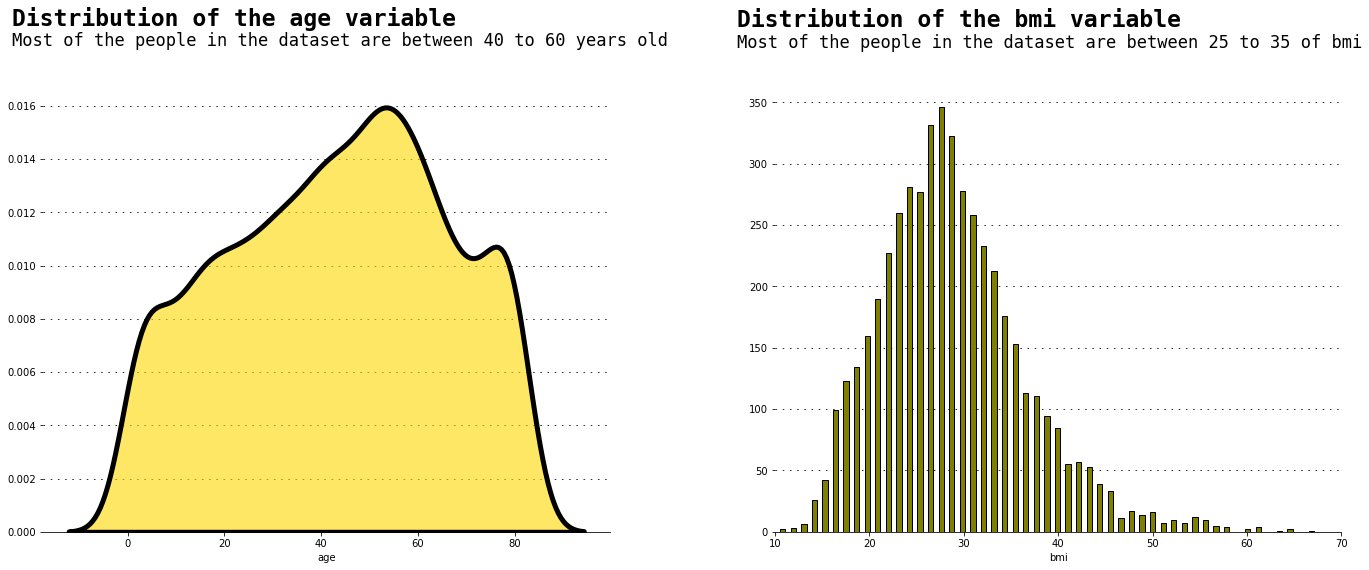

In [877]:
fig=pyplot.figure(figsize=(20,8),facecolor='white')
gs=fig.add_gridspec(1,2)
ax=[None for i in range(2)]
ax[0]=fig.add_subplot(gs[0,0])
ax[1]=fig.add_subplot(gs[0,1])

ax[0].text(-24,0.019,'Distribution of the age variable',fontsize=23,fontweight='bold', fontfamily='monospace')
ax[0].text(-24,0.01826,'Most of the people in the dataset are between 40 to 60 years old',fontsize=17,fontweight='light', fontfamily='monospace')

ax[1].text(6,412,'Distribution of the bmi variable',fontsize=23,fontweight='bold', fontfamily='monospace')
ax[1].text(6,395,'Most of the people in the dataset are between 25 to 35 of bmi',fontsize=17,fontweight='light', fontfamily='monospace')

sns.kdeplot(x=stroke['age'],ax=ax[0],shade=True, color='gold', alpha=0.6,zorder=3,linewidth=5,edgecolor='black')
sns.histplot(x=stroke['bmi'],ax=ax[1], color='olive', alpha=1,zorder=2,linewidth=1,edgecolor='black',shrink=0.5)

for i in range(2):
    ax[i].set_ylabel('')
    ax[i].grid(which='both', axis='y', zorder=0, color='black', linestyle=':', dashes=(2,7))
    
    for direction in ['top','right','left']:
        ax[i].spines[direction].set_visible(False)
        
ax[1].set_xlim(10,70)
        
pyplot.tight_layout()

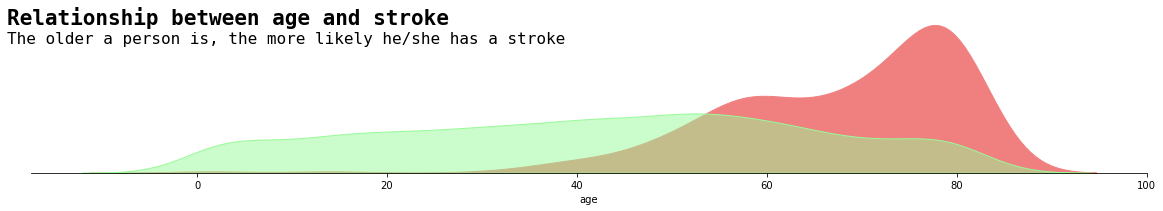

In [878]:
fig=pyplot.figure(figsize=(20,8),facecolor='white')

ax=[None for i in range(1)]
gs=fig.add_gridspec(2,1)
gs.update(wspace=0, hspace=0.8)

ax[0]=fig.add_subplot(gs[0,0])

ax[0].text(-20,0.04,'Relationship between age and stroke',fontsize=21,fontweight='bold', fontfamily='monospace')
ax[0].text(-20,0.035,'The older a person is, the more likely he/she has a stroke',fontsize=16,fontweight='light', fontfamily='monospace')

sns.kdeplot(data=stroke[stroke.stroke==1],x='age',ax=ax[0],shade=True,color='lightcoral',alpha=1)
sns.kdeplot(data=stroke[stroke.stroke==0],x='age',ax=ax[0],shade=True,color='palegreen',alpha=0.5)

for i in range(1):
    ax[i].set_yticklabels('')
    ax[i].set_ylabel('')
    ax[i].tick_params(axis='y',length=0)
    
    for direction in ['top','right','left']:
        ax[i].spines[direction].set_visible(False)

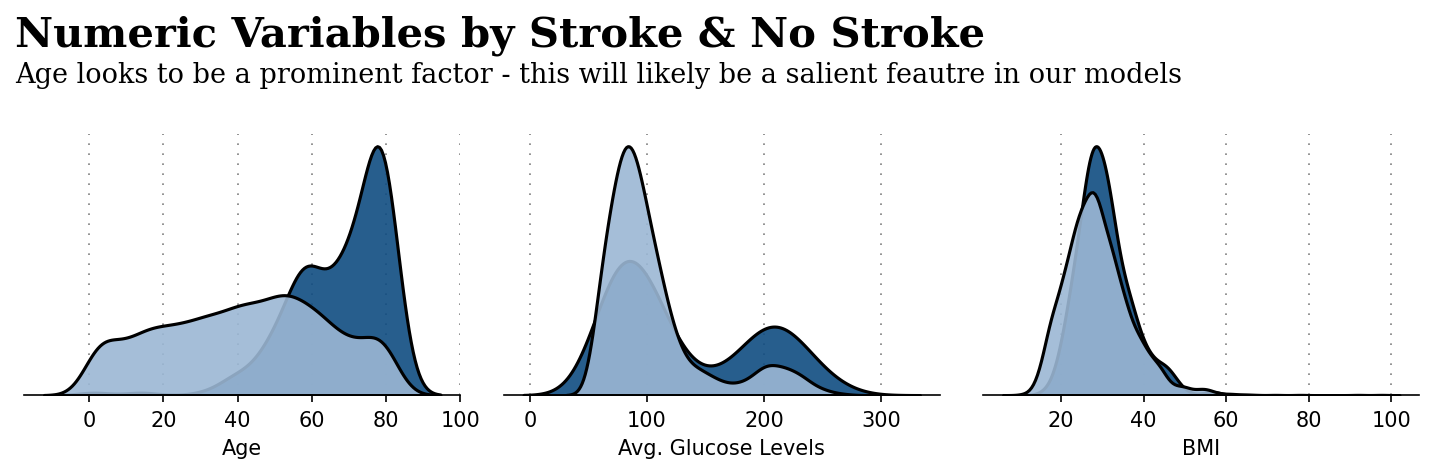

In [879]:
conts = ['age','avg_glucose_level','bmi']

fig = pyplot.figure(figsize=(12, 12), dpi=150,facecolor='white')
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.1, hspace=0.4)


plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].set_facecolor('white')
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0

s = stroke[stroke['stroke'] == 1]
ns = stroke[stroke['stroke'] == 0]

for feature in conts:
        sns.kdeplot(s[feature], ax=locals()["ax"+str(plot)], color='#0f4c81', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        sns.kdeplot(ns[feature],ax=locals()["ax"+str(plot)], color='#9bb7d4', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
        #locals()["ax"+str(plot)].set_xlabel(feature)
        plot += 1

ax0.set_xlabel('Age')
ax1.set_xlabel('Avg. Glucose Levels')
ax2.set_xlabel('BMI')
        
ax0.text(-20, 0.056, 'Numeric Variables by Stroke & No Stroke', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-20, 0.05, 'Age looks to be a prominent factor - this will likely be a salient feautre in our models', 
         fontsize=13, fontweight='light', fontfamily='serif')

pyplot.show()

# 3. Pré-processamento dos dados

In [880]:
stroke = stroke.dropna() # Retira as amostras que faltam algum parâmetro
print(stroke.shape)
stroke.isnull().values.sum()

(4909, 12)


0

In [881]:
stroke = stroke.drop(stroke[stroke['sex'] == 'Other'].index[0])
stroke.groupby('stroke').count()

,id,sex,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status
stroke,,,,,,,,,,,
0,4699,4699,4699,4699,4699,4699,4699,4699,4699,4699,4699
1,209,209,209,209,209,209,209,209,209,209,209


## 3.1 Codificando as features: Strings -> Inteiros

In [882]:
# create a mapping dict
sex_mapping = {label: idx for idx, label in enumerate(np.unique(stroke['sex']))}
ever_married_mapping = {label: idx for idx, label in enumerate(np.unique(stroke['ever_married']))}
work_type_mapping = {label: idx for idx, label in enumerate(np.unique(stroke['work_type']))}
residence_type_mapping = {label: idx for idx, label in enumerate(np.unique(stroke['residence_type']))}
smoking_status_mapping = {label: idx for idx, label in enumerate(np.unique(stroke['smoking_status']))}
print(sex_mapping)
print(ever_married_mapping)
print(work_type_mapping)
print(residence_type_mapping)
print(smoking_status_mapping)
# convert class labels from strings to integers
stroke['sex'] = stroke['sex'].map(sex_mapping)
stroke['ever_married'] = stroke['ever_married'].map(ever_married_mapping)
stroke['work_type'] = stroke['work_type'].map(work_type_mapping)
stroke['residence_type'] = stroke['residence_type'].map(residence_type_mapping)
stroke['smoking_status'] = stroke['smoking_status'].map(smoking_status_mapping)
print(stroke.dtypes)
stroke.head()

{'Female': 0, 'Male': 1}
{'No': 0, 'Yes': 1}
{'Govt_job': 0, 'Never_worked': 1, 'Private': 2, 'Self-employed': 3, 'children': 4}
{'Rural': 0, 'Urban': 1}
{'Unknown': 0, 'formerly smoked': 1, 'never smoked': 2, 'smokes': 3}
id                     int64
sex                    int64
age                  float64
hypertension           int64
heart_disease          int64
ever_married           int64
work_type              int64
residence_type         int64
avg_glucose_level    float64
bmi                  float64
smoking_status         int64
stroke                 int64
dtype: object


,id,sex,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.6,1,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.5,2,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.0,2,1
5,56669,1,81.0,0,0,1,2,1,186.21,29.0,1,1


In [883]:
y = stroke['stroke'].values
X = stroke.copy()
del X['stroke']
del X['id']
X = X.values
X.shape

(4908, 10)

In [884]:
# summarize class distribution
counter = Counter(y)
print(counter)

Counter({0: 4699, 1: 209})


## 3.2. SMOTE - Synthetic Minority Oversampling Technique

In [885]:
# transform the dataset
oversample = SMOTE(sampling_strategy='minority', random_state=42, k_neighbors=1) # Default: k_neighbors=5
X_smote, y_smote = oversample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y_smote)
print(counter)

Counter({1: 4699, 0: 4699})


# 4. Modelos preditivos de classificação

In [886]:
# separando os dados aleatoriamente em 70%/30%
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42, stratify=y)
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, train_size=0.7, random_state=42, stratify=y_smote)

In [887]:
# Normalizando os dados
mms = MinMaxScaler()

X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

X_train_smote_norm = mms.fit_transform(X_train_smote)
X_test_smote_norm = mms.transform(X_test_smote)

In [888]:
# Standardizando os dados
stdsc = StandardScaler()

X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

X_train_smote_std = stdsc.fit_transform(X_train_smote)
X_test_smote_std = stdsc.transform(X_test_smote)

In [889]:
quantidade_de_modelos = 1

# criando os modelos kNN
modelokNN = []
for idx in range(quantidade_de_modelos) :
    modelokNN.append(KNeighborsClassifier(n_neighbors=(idx+1)))

# treinando o modelo
for idx in range(quantidade_de_modelos) :
    modelokNN[idx].fit(X_train, y_train)

# predizendo as amostras de teste
y_pred = []
for idx in range(quantidade_de_modelos) :
    y_pred.append(np.array(modelokNN[idx].predict(X_test)))

In [890]:
# criando os modelos kNN com os dados normalizados
modelokNN_norm = []
for idx in range(quantidade_de_modelos) :
    modelokNN_norm.append(KNeighborsClassifier(n_neighbors=(idx+1)))

# treinando o modelo
for idx in range(quantidade_de_modelos) :
    modelokNN_norm[idx].fit(X_train_norm, y_train)

# predizendo as amostras de teste
y_pred_norm = []
for idx in range(quantidade_de_modelos) :
    y_pred_norm.append(np.array(modelokNN_norm[idx].predict(X_test_norm)))

In [891]:
# criando os modelos kNN com os dados standardizados
modelokNN_std = []
for idx in range(quantidade_de_modelos) :
    modelokNN_std.append(KNeighborsClassifier(n_neighbors=(idx+1)))

# treinando o modelo
for idx in range(quantidade_de_modelos) :
    modelokNN_std[idx].fit(X_train_std, y_train)

# predizendo as amostras de teste
y_pred_std = []
for idx in range(quantidade_de_modelos) :
    y_pred_std.append(np.array(modelokNN_std[idx].predict(X_test_std)))

In [892]:
# criando os modelos kNN usando SMOTE
modelokNN_smote = []
for idx in range(quantidade_de_modelos) :
    modelokNN_smote.append(KNeighborsClassifier(n_neighbors=(idx+1)))

# treinando o modelo
for idx in range(quantidade_de_modelos) :
    modelokNN_smote[idx].fit(X_train_smote, y_train_smote)

# predizendo as amostras de teste
y_pred_smote = []
for idx in range(quantidade_de_modelos) :
    y_pred_smote.append(np.array(modelokNN_smote[idx].predict(X_test_smote)))

In [893]:
# criando os modelos kNN usando SMOTE e dados normalizados
modelokNN_smote_norm = []
for idx in range(quantidade_de_modelos) :
    modelokNN_smote_norm.append(KNeighborsClassifier(n_neighbors=(idx+1)))

# treinando o modelo
for idx in range(quantidade_de_modelos) :
    modelokNN_smote_norm[idx].fit(X_train_smote_norm, y_train_smote)

# predizendo as amostras de teste
y_pred_smote_norm = []
for idx in range(quantidade_de_modelos) :
    y_pred_smote_norm.append(np.array(modelokNN_smote_norm[idx].predict(X_test_smote_norm)))

In [894]:
# criando os modelos kNN usando SMOTE e dados standardizados
modelokNN_smote_std = []
for idx in range(quantidade_de_modelos) :
    modelokNN_smote_std.append(KNeighborsClassifier(n_neighbors=(idx+1)))

# treinando o modelo
for idx in range(quantidade_de_modelos) :
    modelokNN_smote_std[idx].fit(X_train_smote_std, y_train_smote)

# predizendo as amostras de teste
y_pred_smote_std = []
for idx in range(quantidade_de_modelos) :
    y_pred_smote_std.append(np.array(modelokNN_smote_std[idx].predict(X_test_smote_std)))

In [895]:
# Escalonando os dados em um pipeline, depois dividindo
rf_pipeline = Pipeline(steps = [('scale',StandardScaler()),('RF',RandomForestClassifier(random_state=42))])
svm_pipeline = Pipeline(steps = [('scale',StandardScaler()),('SVM',SVC(random_state=42))])
logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(random_state=42))])

rf_cv = cross_val_score(rf_pipeline,X_train_smote_std,y_train_smote,cv=10,scoring='f1')
svm_cv = cross_val_score(svm_pipeline,X_train_smote_std,y_train_smote,cv=10,scoring='f1')
logreg_cv = cross_val_score(logreg_pipeline,X_train_smote_std,y_train_smote,cv=10,scoring='f1')

In [896]:
rf_cv = cross_val_score(rf_pipeline,X_train_smote_std,y_train_smote,cv=10,scoring='f1').mean()
svc_cv = cross_val_score(svm_pipeline,X_train_smote_std,y_train_smote,cv=10,scoring='f1').mean()
lr_cv = cross_val_score(logreg_pipeline,X_train_smote_std,y_train_smote,cv=10,scoring='f1').mean()

rf_pipeline.fit(X_train_smote_std,y_train_smote)
svm_pipeline.fit(X_train_smote_std,y_train_smote)
logreg_pipeline.fit(X_train_smote_std,y_train_smote)

rf_pred = rf_pipeline.predict(X_test_smote_std)
svm_pred = svm_pipeline.predict(X_test_smote_std)
logreg_pred = logreg_pipeline.predict(X_test_smote_std)

# 5. Métricas de avaliação dos resultados

## 5.1. Acurácia

In [897]:
for idx in range(quantidade_de_modelos) :
    print(metrics.accuracy_score(y_test, y_pred[idx])) # DADOS CRUS

0.923285811269518


In [898]:
for idx in range(quantidade_de_modelos) :
    print(metrics.accuracy_score(y_test, y_pred_norm[idx])) # DADOS CRUS NORMALIZADOS

0.9226069246435845


In [899]:
for idx in range(quantidade_de_modelos) :
    print(metrics.accuracy_score(y_test, y_pred_std[idx])) # DADOS CRUS STANDARDIZADOS

0.9198913781398507


In [900]:
for idx in range(quantidade_de_modelos) :
    print(metrics.accuracy_score(y_test_smote, y_pred_smote[idx])) # DADOS UTILIZANDO OVERSAMPLING(SMOTE)

0.9631205673758865


In [901]:
for idx in range(quantidade_de_modelos) :
    print(metrics.accuracy_score(y_test_smote, y_pred_smote_norm[idx])) # DADOS UTILIZANDO OVERSAMPLING(SMOTE) E NORMALIZADO

0.9687943262411347


In [902]:
for idx in range(quantidade_de_modelos) :
    print(metrics.accuracy_score(y_test_smote, y_pred_smote_std[idx])) # DADOS UTILIZANDO OVERSAMPLING(SMOTE) E STANDARDIZADO

0.9695035460992908


## 5.2. Precisão

In [903]:
for idx in range(quantidade_de_modelos) :
    print(metrics.precision_score(y_test, y_pred[idx], average='weighted', zero_division=0)) # DADOS CRUS

0.9249959897131373


In [904]:
for idx in range(quantidade_de_modelos) :
    print(metrics.precision_score(y_test, y_pred_norm[idx], average='weighted', zero_division=0)) # DADOS CRUS NORMALIZADOS

0.9270677626134621


In [905]:
for idx in range(quantidade_de_modelos) :
    print(metrics.precision_score(y_test, y_pred_std[idx], average='weighted', zero_division=0)) # DADOS CRUS STANDARDIZADOS

0.9222536516514689


In [906]:
for idx in range(quantidade_de_modelos) :
    print(metrics.precision_score(y_test_smote, y_pred_smote[idx], average='weighted', zero_division=0)) # DADOS UTILIZANDO OVERSAMPLING(SMOTE)

0.9655568904422116


In [907]:
for idx in range(quantidade_de_modelos) :
    print(metrics.precision_score(y_test_smote, y_pred_smote_norm[idx], average='weighted', zero_division=0)) # DADOS UTILIZANDO OVERSAMPLING(SMOTE) E NORMALIZADO

0.9698872081134331


In [908]:
for idx in range(quantidade_de_modelos) :
    print(metrics.precision_score(y_test_smote, y_pred_smote_std[idx], average='weighted', zero_division=0)) # DADOS UTILIZANDO OVERSAMPLING(SMOTE) E STANDARDIZADO

0.9710198314578391


## 5.3. Recall

In [909]:
for idx in range(quantidade_de_modelos) :
    print(metrics.recall_score(y_test, y_pred[idx], average='weighted', zero_division=0)) # DADOS CRUS

0.923285811269518


In [910]:
for idx in range(quantidade_de_modelos) :
    print(metrics.recall_score(y_test, y_pred_norm[idx], average='weighted', zero_division=0)) # DADOS CRUS NORMALIZADOS

0.9226069246435845


In [911]:
for idx in range(quantidade_de_modelos) :
    print(metrics.recall_score(y_test, y_pred_std[idx], average='weighted', zero_division=0)) # DADOS CRUS STANDARDIZADOS

0.9198913781398507


In [912]:
for idx in range(quantidade_de_modelos) :
    print(metrics.recall_score(y_test_smote, y_pred_smote[idx], average='weighted', zero_division=0)) # DADOS UTILIZANDO OVERSAMPLING(SMOTE)

0.9631205673758865


In [913]:
for idx in range(quantidade_de_modelos) :
    print(metrics.recall_score(y_test_smote, y_pred_smote_norm[idx], average='weighted', zero_division=0)) # DADOS UTILIZANDO OVERSAMPLING(SMOTE) E NORMALIZADO

0.9687943262411347


In [914]:
for idx in range(quantidade_de_modelos) :
    print(metrics.recall_score(y_test_smote, y_pred_smote_std[idx], average='weighted', zero_division=0)) # DADOS UTILIZANDO OVERSAMPLING(SMOTE) E STANDARDIZADOS

0.9695035460992908


## 5.4. F1-Measure

In [915]:
f1_scores = []

In [916]:
for idx in range(quantidade_de_modelos) :
    print(metrics.f1_score(y_test, y_pred[idx], average='weighted', zero_division=0)) # DADOS CRUS
f1_scores.append(metrics.f1_score(y_test, y_pred[0], average='weighted', zero_division=0))

0.9241369878440843


In [917]:
for idx in range(quantidade_de_modelos) :
    print(metrics.f1_score(y_test, y_pred_norm[idx], average='weighted', zero_division=0)) # DADOS CRUS NORMALIZADOS
f1_scores.append(metrics.f1_score(y_test, y_pred_norm[0], average='weighted', zero_division=0))

0.9248070759758755


In [918]:
for idx in range(quantidade_de_modelos) :
    print(metrics.f1_score(y_test, y_pred_std[idx], average='weighted', zero_division=0)) # DADOS CRUS STANDARDIZADOS
f1_scores.append(metrics.f1_score(y_test, y_pred_std[0], average='weighted', zero_division=0))

0.9210669231481349


In [919]:
for idx in range(quantidade_de_modelos) :
    print(metrics.f1_score(y_test_smote, y_pred_smote[idx], average='weighted', zero_division=0)) # DADOS UTILIZANDO OVERSAMPLING(SMOTE)
f1_scores.append(metrics.f1_score(y_test_smote, y_pred_smote[0], average='weighted', zero_division=0))

0.9630722553876885


In [920]:
for idx in range(quantidade_de_modelos) :
    print(metrics.f1_score(y_test_smote, y_pred_smote_norm[idx], average='weighted', zero_division=0)) # DADOS UTILIZANDO OVERSAMPLING(SMOTE) E NORMALIZADO
f1_scores.append(metrics.f1_score(y_test_smote, y_pred_smote_norm[0], average='weighted', zero_division=0))

0.9687761708432648


In [921]:
for idx in range(quantidade_de_modelos) :
    print(metrics.f1_score(y_test_smote, y_pred_smote_std[idx], average='weighted', zero_division=0)) # DADOS UTILIZANDO OVERSAMPLING(SMOTE) E STANDARDIZADO
f1_scores.append(metrics.f1_score(y_test_smote, y_pred_smote_std[0], average='weighted', zero_division=0))

0.9694789831361691


In [922]:
print('Mean f1 scores:')
print('Random Forest mean :', rf_cv)
print('SVM mean :', svc_cv)
print('Logistic Regression mean :', lr_cv)

f1_scores.append(rf_cv)
f1_scores.append(svc_cv)
f1_scores.append(lr_cv)

Mean f1 scores:
Random Forest mean : 0.9733835707195391
SVM mean : 0.923090812742075
Logistic Regression mean : 0.778301406749636


In [923]:
rf_f1  = metrics.f1_score(y_test_smote, rf_pred)
svm_f1 = metrics.f1_score(y_test_smote, svm_pred)
logreg_f1 = metrics.f1_score(y_test_smote, logreg_pred)

# 6. Apresentação dos resultados

In [924]:
stroke.corr()

,id,sex,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,1.000000,0.006474,0.009124,0.001206,0.004058,0.017099,-0.022617,0.005167,0.006252,0.003238,0.018549,0.004878
sex,0.006474,1.000000,-0.030280,0.021811,0.082950,-0.036380,0.058725,-0.004351,0.053161,-0.026164,-0.059837,0.006904
age,0.009124,-0.030280,1.000000,0.274395,0.257104,0.680742,-0.367033,0.010795,0.236000,0.333314,0.275481,0.232313
hypertension,0.001206,0.021811,0.274395,1.000000,0.115978,0.162350,-0.052760,-0.001140,0.180614,0.167770,0.110788,0.142503
heart_disease,0.004058,0.082950,0.257104,0.115978,1.000000,0.111203,-0.030381,-0.002409,0.154577,0.041322,0.055221,0.137929
ever_married,0.017099,-0.036380,0.680742,0.162350,0.111203,1.000000,-0.358059,0.004707,0.151657,0.341553,0.264598,0.105051
work_type,-0.022617,0.058725,-0.367033,-0.052760,-0.030381,-0.358059,1.000000,-0.005455,-0.050558,-0.304924,-0.310927,-0.033763
residence_type,0.005167,-0.004351,0.010795,-0.001140,-0.002409,0.004707,-0.005455,1.000000,-0.007441,-0.000293,0.013739,0.005988
avg_glucose_level,0.006252,0.053161,0.236000,0.180614,0.154577,0.151657,-0.050558,-0.007441,1.000000,0.175672,0.066403,0.138984
bmi,0.003238,-0.026164,0.333314,0.167770,0.041322,0.341553,-0.304924,-0.000293,0.175672,1.000000,0.224432,0.042341


In [925]:
print(metrics.classification_report(y_test, y_pred_norm[0]))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1410
           1       0.14      0.16      0.15        63

    accuracy                           0.92      1473
   macro avg       0.55      0.56      0.55      1473
weighted avg       0.93      0.92      0.92      1473



In [926]:
print(metrics.classification_report(y_test_smote, y_pred_smote_std[0]))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1410
           1       0.94      1.00      0.97      1410

    accuracy                           0.97      2820
   macro avg       0.97      0.97      0.97      2820
weighted avg       0.97      0.97      0.97      2820



In [927]:
print(metrics.classification_report(y_test_smote,rf_pred))

print('Accuracy Score: ', metrics.accuracy_score(y_test_smote, rf_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1410
           1       0.99      0.97      0.98      1410

    accuracy                           0.98      2820
   macro avg       0.98      0.98      0.98      2820
weighted avg       0.98      0.98      0.98      2820

Accuracy Score:  0.9790780141843972


In [928]:
print(metrics.classification_report(y_test_smote, svm_pred))

print('Accuracy Score: ', metrics.accuracy_score(y_test_smote, svm_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1410
           1       0.93      0.93      0.93      1410

    accuracy                           0.93      2820
   macro avg       0.93      0.93      0.93      2820
weighted avg       0.93      0.93      0.93      2820

Accuracy Score:  0.9276595744680851


In [929]:
print(metrics.classification_report(y_test_smote, logreg_pred))

print('Accuracy Score: ', metrics.accuracy_score(y_test_smote, logreg_pred)) 

              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1410
           1       0.76      0.79      0.77      1410

    accuracy                           0.77      2820
   macro avg       0.77      0.77      0.77      2820
weighted avg       0.77      0.77      0.77      2820

Accuracy Score:  0.7709219858156028


In [930]:
def hist_graph_precision_others(y, title):
    labels = ['KNN(k=1)', 'KNN-norm(k=1)', 'KNN-std(k=1)', 'KNN-SMOTE(k=1)', 'KNN-SMOTE-norm(k=1)', 'KNN-SMOTE-std(k=1)','Logistic Regression', 'Decision Tree', 'Random Forest']
    fig = px.bar(x=labels, y=y, color=labels, title=title, text=y,
        labels=dict(x="Algorithms", y="F1-Scores", color="Algorithm")
    )
    fig.update_traces(texttemplate='%{text:.2%}', textposition='outside')
    fig.show()

In [931]:
hist_graph_precision_others(f1_scores, "F1-Scores de 9 diferentes abordagens")